In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

In [1]:
obs_times=(10, 20, 100)

obs_s1=(7.1, 9.3, 12.7)
var_s1=(1.9, 3.5, 5.2)

obs_s2=(0.3, 0.4, 0.5)
var_s2=(0.1, 0.2, 0.2)


In [2]:
def dynamics(x, t, k0, Vm1, k2, KM1):
       dx=[0,0] #generate a list to store derivatives
       
       S1=x[0]
       S2=x[1]
       
       V0=k0
       V1=Vm1*S1/(KM1*(10+S2)+S1) 
       V2=k2*S2
       
       dx[0]= V0-V1
       dx[1]= V1-V2

       return dx

In [3]:
def calc_SSE(p):
    
    times=np.linspace(0,101,101) #generate time-grid list
    x0=[0,0] #specify initial condition

    x=odeint(dynamics, x0, times, args=tuple(p)) #run simulation
    
    SSE=0
    for i in range(3):
        SSE=SSE+(obs_s1[i] - x[obs_times[i], 0])**2/var_s1[i]
        SSE=SSE+(obs_s2[i] - x[obs_times[i], 1])**2/var_s2[i]
    
    return SSE

In [6]:
initial_guess=[1,1,1,1]    
res = minimize(calc_SSE, initial_guess, method='nelder-mead',
               options={'xatol': 1e-10, 'disp': True, 'maxiter': 5000})
    
print(res.x)

Optimization terminated successfully.
         Current function value: 0.049244
         Iterations: 313
         Function evaluations: 593
[1.47785782 2.48404858 3.28331285 0.82851842]


In [7]:
p=res.x

PLotting fit 

Text(0.5, 0, 'time')

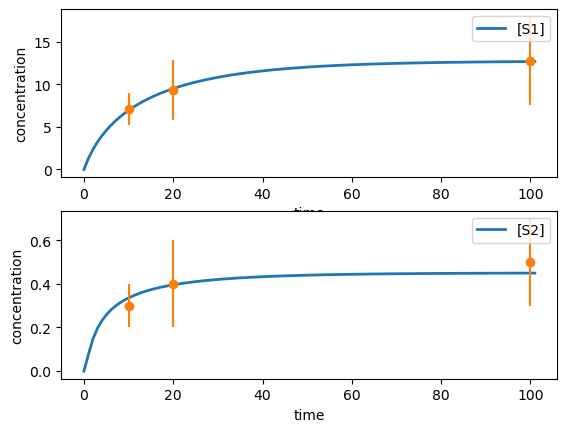

In [8]:
times = np.linspace(0, 101, 101)  # generate time-grid list
x0 = [0, 0]  # specify initial condition


x = odeint(dynamics, x0, times, args=tuple(p))  # run simulation

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(times, x[:, 0], label="[S1]", linewidth=2)
ax2.plot(times, x[:, 1], label="[S2]", linewidth=2)

ax1.errorbar(obs_times, obs_s1, yerr=var_s1, marker='o', linestyle='none')
ax2.errorbar(obs_times, obs_s2, yerr=var_s2, marker='o', linestyle='none')
ax1.legend()
ax1.set_ylabel("concentration")
ax1.set_xlabel("time")
ax2.legend()
ax2.set_ylabel("concentration")
ax2.set_xlabel("time")

Sensitivities

In [14]:
nom_pars = res.x
delta = 0.01

In [15]:
x_nom = odeint(dynamics, x0, times, args=tuple(nom_pars))
sens = np.zeros((6, 4))
for i in range(4): # parameters

    #forward perturbation
    pars_local = nom_pars.copy()
    pars_local[i] = pars_local[i]*(1+delta)
    x_pert_f = odeint(dynamics, x0, times, args=tuple(pars_local))
    
    #backward perturbation
    pars_local = nom_pars.copy()
    pars_local[i] = pars_local[i]*(1-delta)
    x_pert_r = odeint(dynamics, x0, times, args=tuple(pars_local))

    for j in range(3): # observed time points
        for k in range(2): # observed species
            # sens[2*j+k, i] = 0.5*(x_pert_f[obs_times[j], k] -
            #               x_pert_r[obs_times[j], k])/(delta*x_nom[obs_times[j], k])
            sens[2*j+k, i] = 0.5*(x_pert_f[obs_times[j], k] -
                          x_pert_r[obs_times[j], k])/(delta*x_nom[obs_times[j], k])


In [16]:
print(sens)

[[ 1.30363458 -0.76493795 -0.01233663  0.47397574]
 [ 0.70595033  0.57360217 -0.97977959 -0.29039968]
 [ 1.58600782 -1.19608345 -0.02105957  0.63130644]
 [ 0.7386436   0.42768014 -0.98938003 -0.17423603]
 [ 2.44266136 -2.37724922 -0.04161238  0.97561793]
 [ 0.97497353  0.03438368 -0.99951433 -0.00984388]]


In [17]:
S1=np.sqrt(np.square(sens[:,0]).sum())
S2=np.sqrt(np.square(sens[:,1]).sum())
S3=np.sqrt(np.square(sens[:,2]).sum())
S4=np.sqrt(np.square(sens[:,3]).sum())

S_norm=np.array([S1, S2, S3, S4])

print(S1)
print(S2)
print(S3)
print(S4)

3.4894142849760215
2.8600999186094738
1.7147002859566978
1.29993009335052


In [44]:
###iterateed projection process to determine identifiability via residuals####

number_of_parameters=4

Z=sens

S_norm=np.array([S1, S2, S3])
max_index0=np.argmax(S_norm) #identify the index of the most identifiable
max0=np.max(S_norm)



X = np.empty(shape=[6,0])

indices_in_order_of_most_identifiable=np.zeros(number_of_parameters)
ident_scores_in_order_of_most_identifiable=np.zeros(number_of_parameters)

indices_in_order_of_most_identifiable[0]=max_index0
ident_scores_in_order_of_most_identifiable[0]=max0

previous_max_index=max_index0

for m in np.arange(1, number_of_parameters):
    
    X = np.append(X, np.expand_dims(Z[:,previous_max_index], axis=1), axis=1)

    A1=np.matmul(X, np.linalg.inv(np.matmul(X.transpose(),X)))
    
    A2=np.matmul(np.transpose(X), Z)

    R=Z-np.matmul(A1, A2)

    norms = np.linalg.norm(R, axis=0)
    
    max_index= np.argmax(norms)
    norm_max=np.max(norms)
    
    indices_in_order_of_most_identifiable[m]=max_index
    ident_scores_in_order_of_most_identifiable[m]=norm_max

    previous_max_index=max_index


print(indices_in_order_of_most_identifiable)
print(ident_scores_in_order_of_most_identifiable)

[0. 1. 2. 3.]
[3.48941428 1.7302615  0.48652905 0.10455975]
